## Project - Fraud Detection 💳

###
Fraud detection is a billion dollars business 💰: according to the Nilson Report, credit card fraud adds up to 30 billion dollars in 2021 !

Every bank and insurance company has some fraud detection algorithms. They are working hard to find out the fraudulent transactions amongst a huge number of valid ones.

Some companies are doing really good. For instance, Paypal has developed really complicated and efficient algorithms to perform fraud detection.

👉🏻 Today, we will use our new skills in anomaly detection in order to build our fist fraud detection solution.

⚠️ Once again, do not rush into the model building. Take your time to understand the data and make a proper EDA. Then try to compare both the supervised and unsupervised models performance.

### To use both supervised and unsupervised models

In [1]:
#imports
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.cluster import AgglomerativeClustering
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.metrics import f1_score,recall_score,precision_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.compose import ColumnTransformer
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier

## 1. EDA

###
The dataset contains transactions made by credit cards in September 2013 by European cardholders.
This dataset presents transactions that occurred in two days, where we have 492 frauds out of 284,807 transactions. The dataset is highly unbalanced, the positive class (frauds) account for 0.172% of all transactions.

It contains only numerical input variables which are the result of a PCA transformation. Unfortunately, due to confidentiality issues, we cannot provide the original features and more background information about the data. Features V1, V2, … V28 are the principal components obtained with PCA, the only features which have not been transformed with PCA are 'Time' and 'Amount'. Feature 'Time' contains the seconds elapsed between each transaction and the first transaction in the dataset. The feature 'Amount' is the transaction Amount, this feature can be used for example-dependant cost-sensitive learning. Feature 'Class' is the response variable and it takes value 1 in case of fraud and 0 otherwise.

Given the class imbalance ratio, we recommend measuring the accuracy using the Area Under the Precision-Recall Curve (AUPRC). Confusion matrix accuracy is not meaningful for unbalanced classification.

In [2]:
# read the dataset as a dataframe
df = pd.read_csv('../creditcard.csv')
print(f'head: {df.head()}')
print(f'shape: {df.shape}') ##284807, 31 !!!
print(f'columns: {df.columns}')

head:    Time        V1        V2        V3        V4        V5        V6        V7  \
0   0.0 -1.359807 -0.072781  2.536347  1.378155 -0.338321  0.462388  0.239599   
1   0.0  1.191857  0.266151  0.166480  0.448154  0.060018 -0.082361 -0.078803   
2   1.0 -1.358354 -1.340163  1.773209  0.379780 -0.503198  1.800499  0.791461   
3   1.0 -0.966272 -0.185226  1.792993 -0.863291 -0.010309  1.247203  0.237609   
4   2.0 -1.158233  0.877737  1.548718  0.403034 -0.407193  0.095921  0.592941   

         V8        V9  ...       V21       V22       V23       V24       V25  \
0  0.098698  0.363787  ... -0.018307  0.277838 -0.110474  0.066928  0.128539   
1  0.085102 -0.255425  ... -0.225775 -0.638672  0.101288 -0.339846  0.167170   
2  0.247676 -1.514654  ...  0.247998  0.771679  0.909412 -0.689281 -0.327642   
3  0.377436 -1.387024  ... -0.108300  0.005274 -0.190321 -1.175575  0.647376   
4 -0.270533  0.817739  ... -0.009431  0.798278 -0.137458  0.141267 -0.206010   

        V26       V27     

In [3]:
print(f'columns: {df.columns}')

columns: Index(['Time', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6', 'V7', 'V8', 'V9', 'V10',
       'V11', 'V12', 'V13', 'V14', 'V15', 'V16', 'V17', 'V18', 'V19', 'V20',
       'V21', 'V22', 'V23', 'V24', 'V25', 'V26', 'V27', 'V28', 'Amount',
       'Class'],
      dtype='object')


### le dataset est-il labellisé ? si l'on veut utiliser des modèles supervisés
oui la target est 'Class'

In [4]:
df['Class'].unique() #0 / 1 ok

array([0, 1])

In [5]:
# données manquantes: s'assurer qu'il n'y a pas de valeurs invalides différentes de Nan !!
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
## numeric_features
numeric_features = [col for col in df.columns if col not in ['Time','Churn']]

In [7]:
df.isna().value_counts()
for col in df.columns:
    if df[col].isna().sum() > 0:
        print(f'{col}: {df[col].isna().sum()}')

# PAS DE DONNEES MANQUANTES

In [8]:
## données dupliquées?
df.duplicated().sum()
# Oui : 1081 dupliquées
# suppression des lignes dupliquées
df.drop_duplicates(keep='first', inplace=True)
df.shape

(283726, 31)

In [9]:
df['Class'].value_counts()
## extremly unbalanced dataset
## il faudra utiliser imb__ dans un pipeline pour faire du downsampling

0    283253
1       473
Name: Class, dtype: int64

### Types de features

In [10]:
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,...,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000,283726.000000
mean,94811.077600,0.005917,-0.004135,0.001613,-0.002966,0.001828,-0.001139,0.001801,-0.000854,-0.001596,...,-0.000371,-0.000015,0.000198,0.000214,-0.000232,0.000149,0.001763,0.000547,88.472687,0.001667
std,47481.047891,1.948026,1.646703,1.508682,1.414184,1.377008,1.331931,1.227664,1.179054,1.095492,...,0.723909,0.724550,0.623702,0.605627,0.521220,0.482053,0.395744,0.328027,250.399437,0.040796
min,0.000000,-56.407510,-72.715728,-48.325589,-5.683171,-113.743307,-26.160506,-43.557242,-73.216718,-13.434066,...,-34.830382,-10.933144,-44.807735,-2.836627,-10.295397,-2.604551,-22.565679,-15.430084,0.000000,0.000000
25%,54204.750000,-0.915951,-0.600321,-0.889682,-0.850134,-0.689830,-0.769031,-0.552509,-0.208828,-0.644221,...,-0.228305,-0.542700,-0.161703,-0.354453,-0.317485,-0.326763,-0.070641,-0.052818,5.600000,0.000000
50%,84692.500000,0.020384,0.063949,0.179963,-0.022248,-0.053468,-0.275168,0.040859,0.021898,-0.052596,...,-0.029441,0.006675,-0.011159,0.041016,0.016278,-0.052172,0.001479,0.011288,22.000000,0.000000
75%,139298.000000,1.316068,0.800283,1.026960,0.739647,0.612218,0.396792,0.570474,0.325704,0.595977,...,0.186194,0.528245,0.147748,0.439738,0.350667,0.240261,0.091208,0.078276,77.510000,0.000000
max,172792.000000,2.454930,22.057729,9.382558,16.875344,34.801666,73.301626,120.589494,20.007208,15.594995,...,27.202839,10.503090,22.528412,4.584549,7.519589,3.517346,31.612198,33.847808,25691.160000,1.000000


### datetime : Time: voir comment l'utiliser !!
#### j'exclus 'Time' dans un 1er temps

## 2. Feature Engineering

### Build X, y

In [11]:
### ICI TIME EST DROPPED dans un 1er temps !! 
y = df['Class'].to_numpy()
X = df.drop(columns=['Class', 'Time'], axis=1)
print(f'y.shape: {y.shape}')
print(f'X.shape: {X.shape}')

y.shape: (283726,)
X.shape: (283726, 29)


In [12]:
## Train Test splitting
# il faut penser à stratify, a fortiori pour des données imbalanced
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state = 42, stratify=y)

### scaling des Features

In [13]:
# normalisation sur train
X_train = StandardScaler().fit_transform(X_train)

# normalisation sur test
X_test = StandardScaler().fit_transform(X_test)

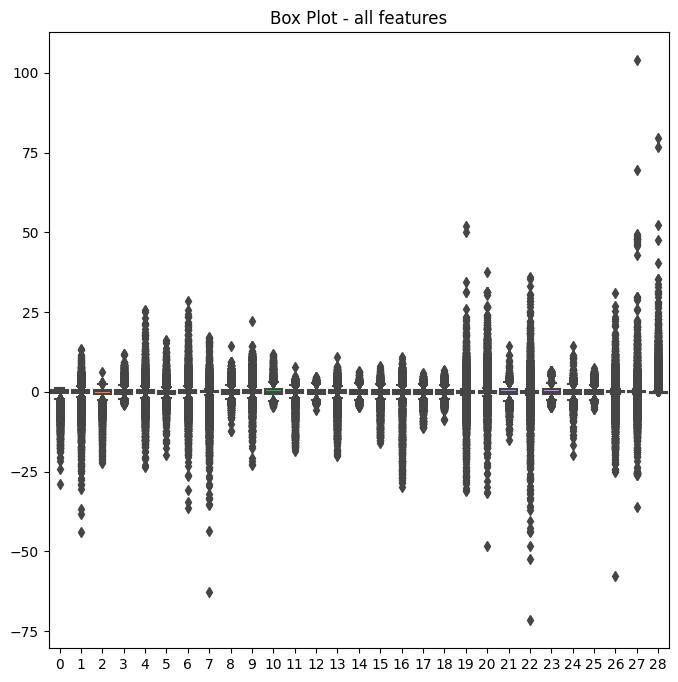

In [14]:
# Boxplots des features numériques standardisées
plt.figure(figsize=(8,8))
plt.title('Box Plot - all features')
sns.boxplot(data=X_train, notch=False);
plt.show()
## énormément de variance dans les features !!

## 3. Supervised Classification Models

#### BASELINE MODEL FOR FRAUD PREDICTION: logistic regression without hyperparam optimization

In [15]:
base_model = LogisticRegression()
base_model.fit(X_train, y_train)

LogisticRegression()

In [16]:
y_pred = base_model.predict(X_test)

### F1-score of base model

In [17]:
def scores_on_fraud_model(model, X_train, X_test, y_train, y_test):

    metrics = {}

    y_train_pred = model.predict(X_train)
    y_test_pred  = model.predict(X_test)

    ## F1-score
    metrics['f1score_train'] = f1score_train = f1_score(y_train, y_train_pred)
    metrics['f1score_test']  = f1score_test  = f1_score(y_test, y_test_pred)

    ## PRECISION
    metrics['precision_train'] = precision_train = precision_score(y_train,y_train_pred)
    metrics['precision_test']  = precision_test  = precision_score(y_test,y_test_pred)

    ## RECALL
    metrics['recall_train'] = recall_train = recall_score(y_train,y_train_pred)
    metrics['recall_test']  = recall_test  = recall_score(y_test,y_test_pred)

    return metrics


### Scores sur le modèle baseline

In [18]:
dict_scores_lr = scores_on_fraud_model(base_model, X_train, X_test, y_train, y_test)
dict_scores_lr

{'f1score_train': 0.7345679012345679,
 'f1score_test': 0.6956521739130435,
 'precision_train': 0.8814814814814815,
 'precision_test': 0.8484848484848485,
 'recall_train': 0.6296296296296297,
 'recall_test': 0.5894736842105263}

### PIPELINES de prétraitements, modèles et scores

In [19]:
## voir le code de Vincent MALARA du 23/05
## pas de categorical features ici
n_components = 8

numeric_transformer = Pipeline(
    steps=[
        ("imputer", KNNImputer()),
        ("scaler", StandardScaler()),
        ("dim_reducer", PCA(n_components=n_components)),
    ]
)

categorical_transformer = Pipeline(
    steps=[
        ("encoder", OneHotEncoder(drop="first")),
    ]
)
preprocessor = ColumnTransformer(
    transformers=[
        ("num", numeric_transformer, numeric_features),
    ]
)

In [20]:
## pipeline avec un modèle
#piple_lr = make_pipeline(preprocessor, LogisticRegression())

## voir comment faire un pipeline avec RandomGridSearchCV !!
## je reprends les fonctions de Vincent dans son correctif du 23/05

In [21]:
## reprise du correctif de Vincent MALARA du 23/05
# Hyperparams de la réduction de dims
#param_grid_prepro = {"preprocessor__num__dim_reducer__n_components": [0.9, 0.95, None]} ## 90%, 95% de variance récupérée avec la dim reduction

param_grid_prepro = {}

In [22]:
## Bug avec cette fonction : à voir + tard
"""
## reprise du correctif de Vincent MALARA du 23/05
def create_pipe_get_score(
    preprocessor, model_name, model, param_grid_model, X_train, y_train, X_test, y_test
):
    param_grid = {**param_grid_prepro, **param_grid_model}
    print(f'param_grid: {param_grid}')

    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])
    print(f'pipe: {pipe}')

    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1")
    grid.fit(X_train, y_train)
    ## le modèle est bien fitté avant de faire appel à la fonction de calcul des métriques sur train et test
    metrics = scores_on_fraud_model(grid, model_name, X_train, y_train, X_test, y_test)
    metrics["best_param"] = grid.best_params_
    return grid, metrics
"""

'\n## reprise du correctif de Vincent MALARA du 23/05\ndef create_pipe_get_score(\n    preprocessor, model_name, model, param_grid_model, X_train, y_train, X_test, y_test\n):\n    param_grid = {**param_grid_prepro, **param_grid_model}\n    print(f\'param_grid: {param_grid}\')\n\n    pipe = Pipeline(steps=[("preprocessor", preprocessor), ("model", model)])\n    print(f\'pipe: {pipe}\')\n\n    grid = GridSearchCV(pipe, param_grid, cv=3, scoring="f1")\n    grid.fit(X_train, y_train)\n    ## le modèle est bien fitté avant de faire appel à la fonction de calcul des métriques sur train et test\n    metrics = scores_on_fraud_model(grid, model_name, X_train, y_train, X_test, y_test)\n    metrics["best_param"] = grid.best_params_\n    return grid, metrics\n'

In [23]:
## reprise du correctif de Vincent MALARA du 23/05
model_list = [
    {
        "name": "LGBMClassifier",
        "model": LGBMClassifier(),
        "param": {},
    },
]
"""
model_list = [
    {
        "name": "logistic_regregression",
        "model": LogisticRegression(),
        "param": {"model__max_iter": [30, 100]},
    },
    {
        "name": "GradientBoostingClassifier",
        "model": GradientBoostingClassifier(),
        "param": {
            "model__loss": ["exponential"],  # "log_loss", "deviance",
            "model__n_estimators": [300],  #
        },
    },
    {
        "name": "LGBMClassifier",
        "model": LGBMClassifier(),
        "param": {},
    },
]
"""

'\nmodel_list = [\n    {\n        "name": "logistic_regregression",\n        "model": LogisticRegression(),\n        "param": {"model__max_iter": [30, 100]},\n    },\n    {\n        "name": "GradientBoostingClassifier",\n        "model": GradientBoostingClassifier(),\n        "param": {\n            "model__loss": ["exponential"],  # "log_loss", "deviance",\n            "model__n_estimators": [300],  #\n        },\n    },\n    {\n        "name": "LGBMClassifier",\n        "model": LGBMClassifier(),\n        "param": {},\n    },\n]\n'

In [24]:
"""
## reprise du correctif de Vincent MALARA du 23/05
results = list()
models_fitted = dict()

for model in model_list:
    print(f'model[name]: {model["name"]}')
    grid, dict_ = create_pipe_get_score(
        preprocessor,
        model["name"],
        model["model"],
        model["param"],
        X_train,
        y_train,
        X_test,
        y_test,
    )
    results.append(dict_)
    models_fitted[model["name"]] = grid
    
df_result = pd.DataFrame(results).sort_values("test_F-score", ascending=False)
"""

'\n## reprise du correctif de Vincent MALARA du 23/05\nresults = list()\nmodels_fitted = dict()\n\nfor model in model_list:\n    print(f\'model[name]: {model["name"]}\')\n    grid, dict_ = create_pipe_get_score(\n        preprocessor,\n        model["name"],\n        model["model"],\n        model["param"],\n        X_train,\n        y_train,\n        X_test,\n        y_test,\n    )\n    results.append(dict_)\n    models_fitted[model["name"]] = grid\n    \ndf_result = pd.DataFrame(results).sort_values("test_F-score", ascending=False)\n'

### dictionnaire des scores sur les modèles testés

In [25]:
dict_scores_models = {}

### Pipeline sur Logistic Regression

In [27]:
## ATTENTION : mettre scoring : 'f1' !!!

### voir comment utiliser preprocessor dans make_pipe
pipe = make_pipeline(StandardScaler(), PCA(), LogisticRegression(C=0.1))
#pipe = make_pipeline(preprocessor, LogisticRegression(C=0.1))
pipe.fit(X_train, y_train)

param_dist = {
    'pca__n_components': np.arange(15, 30),
    'logisticregression__C': [0.1, 0.2],
     }

grid = RandomizedSearchCV(pipe, param_dist, cv=3, n_iter=10, scoring = 'f1')
grid.fit(X_train, y_train)
print(grid.best_params_)

dict_scores_lr = scores_on_fraud_model(grid, X_train, X_test, y_train, y_test)
dict_scores_models['LogisticRegression'] = dict_scores_lr
dict_scores_models


{'pca__n_components': 27, 'logisticregression__C': 0.2}


{'LogisticRegression': {'f1score_train': 0.7326120556414218,
  'f1score_test': 0.6875,
  'precision_train': 0.8810408921933085,
  'precision_test': 0.8461538461538461,
  'recall_train': 0.626984126984127,
  'recall_test': 0.5789473684210527}}

### Pipeline sur XGBC

In [28]:
pipe = make_pipeline(StandardScaler(), PCA(), XGBClassifier())
pipe.fit(X_train, y_train)

param_dist = {
    'pca__n_components': np.arange(15, 30)
}

grid = RandomizedSearchCV(pipe, param_dist, cv=4, n_iter=10, scoring = 'f1')
grid.fit(X_train, y_train)
grid.best_params_

dict_scores_xgbm = scores_on_fraud_model(grid, X_train, X_test, y_train, y_test)
dict_scores_models['XGBMclassifier'] = dict_scores_xgbm
dict_scores_models  ## il doit y avoir une erreur scores très faibles

{'LogisticRegression': {'f1score_train': 0.7326120556414218,
  'f1score_test': 0.6875,
  'precision_train': 0.8810408921933085,
  'precision_test': 0.8461538461538461,
  'recall_train': 0.626984126984127,
  'recall_test': 0.5789473684210527},
 'XGBMclassifier': {'f1score_train': 1.0,
  'f1score_test': 0.8383233532934131,
  'precision_train': 1.0,
  'precision_test': 0.9722222222222222,
  'recall_train': 1.0,
  'recall_test': 0.7368421052631579}}

### Pipeline sur GradientBoostingClassifier

In [197]:
### run trop long: > 10mins
"""
pipe = make_pipeline(StandardScaler(), PCA(), GradientBoostingClassifier())
pipe.fit(X_train, y_train)

param_dist = {
    'pca__n_components': np.arange(15, 30),
    'gradientboostingclassifier__loss': ["exponential"],
    'gradientboostingclassifier__n_estimators': [300]
}

grid = RandomizedSearchCV(pipe, param_dist, cv=3, n_iter=10)
grid.fit(X_train, y_train)
grid.best_params_

dict_scores_gbc = scores_on_fraud_model(grid, X_train, X_test, y_train, y_test)
dict_scores_models['GradientBoostingClassifier'] = dict_scores_gbc
dict_scores_models
"""

### Pipeline avec SVC

In [62]:
pipe = make_pipeline(StandardScaler(), PCA(), SVC())
pipe.fit(X_train, y_train)

param_dist = {
    'pca__n_components': np.arange(15, 30),
    'svc__C': [0.1, 0.2]
}

grid = RandomizedSearchCV(pipe, param_dist, cv=3, n_iter=10)
grid.fit(X_train, y_train)
grid.best_params_

dict_scores_svc = scores_on_fraud_model(grid, X_train, X_test, y_train, y_test)
dict_scores_models['SVC'] = dict_scores_svc
dict_scores_models

### UNDER-SAMPLING
### Pipeline avec under-sampling imblearn avec logistic regression
### pas eu le temps de trouver des exemples avec imblearn: j'utilise class_weight dans la log reg

In [59]:
pipe = make_pipeline(StandardScaler(), PCA(), LogisticRegression(class_weight={0:0.95, 1:0.05}))  ##20:1
#pipe = make_pipeline(preprocessor, LogisticRegression(C=0.1))
pipe.fit(X_train, y_train)

param_dist = {
    'pca__n_components': np.arange(15, 30),
    'logisticregression__C': [0.1, 0.2],
     }

grid = RandomizedSearchCV(pipe, param_dist, cv=3, n_iter=10)
grid.fit(X_train, y_train)
print(grid.best_params_)

dict_scores_lr_cw = scores_on_fraud_model(grid, X_train, X_test, y_train, y_test)
dict_scores_models['LogisticRegression_classweight'] = dict_scores_lr_cw
dict_scores_models

### non c'est nettement mois bien que le modèle de base ...

{'pca__n_components': 27, 'logisticregression__C': 0.2}


{'LogisticRegression': {'f1score_train': 0.7326120556414218,
  'f1score_test': 0.6875,
  'precision_train': 0.8810408921933085,
  'precision_test': 0.8461538461538461,
  'recall_train': 0.626984126984127,
  'recall_test': 0.5789473684210527},
 'LGBMclassifier': {'f1score_train': 0.17492711370262393,
  'f1score_test': 0.18556701030927836,
  'precision_train': 0.1382488479262673,
  'precision_test': 0.1377551020408163,
  'recall_train': 0.23809523809523808,
  'recall_test': 0.28421052631578947},
 'LogisticRegression_classweight': {'f1score_train': 0.4050632911392405,
  'f1score_test': 0.358974358974359,
  'precision_train': 1.0,
  'precision_test': 0.9545454545454546,
  'recall_train': 0.25396825396825395,
  'recall_test': 0.22105263157894736}}